In [15]:
!pip install --user --upgrade --editable gym-env

Obtaining file:///C:/Users/singh/Documents/Foraging_DRL_Project/gym-env
  Attempting uninstall: gym-env
    Found existing installation: gym-env 1.0.0
    Uninstalling gym-env-1.0.0:
      Successfully uninstalled gym-env-1.0.0
  Running setup.py develop for gym-env


# Restart Kernel

In [41]:
import gym
from gym import spaces
import numpy as np
from numpy import random as rand
import random
import math
import matplotlib.pyplot as plt
import sys 

In [42]:
env = gym.make('gym_env:foraging-v101') #normal environment
env = gym.make('gym_env:foraging-v102') #rich patch poor patch environment

In [43]:
def decay(initial, final, stepstoDecay,noEpisodes, type):
    x=np.zeros(noEpisodes)
    
    a=stepstoDecay
    k = np.log(initial/final)/(a-1)
    for e in range(a):
        if type=="linear":
            x[e]=(initial-(e)*(initial-final)/(a-1))
        else:
            x[e]=(initial*np.exp(-(e)*k))
    for e in range(a,noEpisodes):
        x[e]=final     
    return x

In [44]:
def actionSelect(Q,s,epsilon):
    if random.random()>epsilon:
        a = np.argmax(Q[s])
        pos = []
        for i in range(len(Q[s])):
            if(Q[s][i]==Q[s][a]):
                pos.append(i)
        a = random.choice(pos)
    else:
        a = random.randint(0,1)
    return a

# Agents for simple environment

In [45]:
def q_learning(env, gamma, alpha, epsilon, noEpisodes):
    # your code goes here
    Q = np.zeros((25,2))
    Qs = np.zeros((noEpisodes,25,2))
    R = np.zeros(noEpisodes)
    actions = []
    actions.append(0)
    for e in range(noEpisodes):
        alpha0 = alpha[e]
        epsilon0 = epsilon[e]
        s,done = env.reset()
        while not done:
            a = actionSelect(Q,s,epsilon0)
            if e == noEpisodes-1:
                if a==0:
                    actions.append(0)
                else:
                    actions[-1]+=1
            sprime,r,done = env.step(a)
            R[e] += r
            td_target = r
            if not done:
                td_target = td_target + gamma*np.amax(Q[sprime])
            td_error = td_target - Q[s][a]
            Q[s][a] = Q[s][a] + alpha0*td_error
            s = sprime
        Qs[e] = Q
    return R

In [46]:
def double_q_learning(env, gamma, alpha, epsilon, noEpisodes):
    # your code goes here
    Q1 = np.zeros((500,2))
    Qs1 = np.zeros((noEpisodes,500,2))
    Q2 = np.zeros((500,2))
    Qs2 = np.zeros((noEpisodes,500,2))
    Q = np.zeros((500,2))
    Qs = np.zeros((noEpisodes,500,2))
    Vs = np.zeros((noEpisodes,500))
    Ps = np.zeros((noEpisodes,500))
    R = np.zeros(noEpisodes)
    actions = []
    actions.append(0)
    for e in range(noEpisodes):
        alpha0 = alpha[e]
        epsilon0 = epsilon[e]
        s,done = env.reset()
        while not done:
            a = actionSelect(Q,s,epsilon0)
            if e == noEpisodes-1:
                if a==0:
                    actions.append(0)
                else:
                    actions[-1]+=1
            sprime,r,done = env.step(a)
            R[e] += r
            if np.random.randint(0,2):
                aq1 = np.argmax(Q1[sprime])
                td_target = r
                if not done:
                    td_target = td_target + gamma*(Q2[sprime][aq1])
                td_error = td_target - Q1[s][a]
                Q1[s][a] = Q1[s][a] + alpha0*td_error
            else:
                aq2 = np.argmax(Q2[sprime])
                td_target = r
                if not done:
                    td_target = td_target + gamma*(Q1[sprime][aq2])
                td_error = td_target - Q2[s][a]
                Q2[s][a] = Q1[s][a] + alpha0*td_error
            s = sprime
        #Book-Keeping
        Qs1[e] = Q1
        Qs2[e] = Q2
        Q = (Q1+Q2)/2
        Qs[e] = Q
    return R

In [48]:
def r_learning(env, gamma, alpha, epsilon, noEpisodes):
    # your code goes here
    P=np.zeros(noEpisodes)
    rho=0
    Q = np.zeros((500,2))
    Qs = np.zeros((noEpisodes,500,2))
    R = np.zeros(noEpisodes)
    actions = []
    actions.append(0)
    for e in range(noEpisodes):
        alpha0 = alpha[e]
        epsilon0 = epsilon[e]
        s,done = env.reset()
        totalReward=0
        while not done:
            a = actionSelect(Q,s,epsilon0)
            if e == noEpisodes-1:
                if a==0:
                    actions.append(0)
                else:
                    actions[-1]+=1
            # print(a)
            sprime,r,done= env.step(a)
            R[e] += r
            totalReward+=r
            td_target = r
            if not done:
                td_target = td_target + gamma*np.amax(Q[sprime])
            td_error = td_target - Q[s][a]-rho
            # td_error = td_target - Q[s][a]
            Q[s][a] = Q[s][a] + alpha0*td_error
            
            s = sprime
        P[e]=rho
        rho=(e*rho+(totalReward/240))/(e+1)

        Qs[e] = Q
    
    return R

In [49]:
def q_lambda(env, gamma, alpha, epsilon, noEpisodes,lda,replaceTrace):
    # your code goes here
    Q = np.zeros((500,2))
    Qs = np.zeros((noEpisodes,500,2))
    R = np.zeros(noEpisodes)
    E=np.zeros((500,2))
    actions = []
    actions.append(0)
    # print(np.shape(Q)," ",np.shape(E))
    for e in range(noEpisodes):
        alpha0 = alpha[e]
        epsilon0 = epsilon[e]
        s,done = env.reset()
        a = actionSelect(Q,s,epsilon0)
        while not done:
            sprime,r,done=env.step(a)
            aprime = actionSelect(Q,sprime,epsilon0)
            if Q[sprime][aprime]==np.amax(Q[sprime]):
                sprime_greedy = True
            else:
                sprime_greedy = False
            td_target=r 
            R[e] += r
            if not done:
                td_target = td_target + gamma*np.amax(Q[sprime])
            td_error = td_target - Q[s][a]
            if replaceTrace: 
                E[s].fill(0)
            E[s][a]=E[s][a]+1
            # print(np.shape(Q)," ",np.shape(E))
            Q+=alpha0*td_error*E
            if sprime_greedy:
                E=gamma*lda*E
            else:
                E.fill(0)
            s,a=sprime,aprime
        Qs[e] = Q

    return R

In [50]:
def sarsa_lambda(env, gamma, alpha, epsilon, noEpisodes,lda,replaceTrace):
    # your code goes here
    Q = np.zeros((500,2))
    Qs = np.zeros((noEpisodes,500,2))
    R = np.zeros(noEpisodes)
    E=np.zeros((500,2))
    actions = []
    actions.append(0)
    # print(np.shape(Q)," ",np.shape(E))
    for e in range(noEpisodes):
        alpha0 = alpha[e]
        epsilon0 = epsilon[e]
        s,done = env.reset()
        a = actionSelect(Q,s,epsilon0)
        while not done:
            sprime,r,done=env.step(a)
            aprime = actionSelect(Q,sprime,epsilon0)
            td_target=r 
            if not done:
                td_target==td_target+gamma*Q[sprime][aprime]
            R[e] += r
            td_error = td_target - Q[s][a]
            E[s][a]=E[s][a]+1
            if replaceTrace: 
                E=np.clip(E,0,1)
            Q+=alpha0*td_error*E
            E=gamma*lda*E
            s,a=sprime,aprime
        Qs[e] = Q
    return R

In [51]:
alpha1 = decay(1,0.01,1000,1000,"Exp")/1000
alpha2 = decay(1,0.01,1000,1000,"Exp")/1000
alpha3 = decay(1,0.01,1000,1000,"Exp")/1000
alpha4 = decay(1,0.01,1000,1000,"Exp")/1000
alpha5 = decay(1,0.01,1000,1000,"Exp")/1000
alpha6 = decay(1,0.01,1000,1000,"Exp")/1000

epsilon1 = decay(1,0.0001,400,1000,"Exp")
epsilon2 = decay(1,0.0001,400,1000,"Exp")
epsilon3 = decay(1,0.0001,400,1000,"Exp")
epsilon4 = decay(1,0.0001,400,1000,"Exp")
epsilon5 = decay(1,0.0001,400,1000,"Exp")
epsilon6 = decay(1,0.0001,400,1000,"Exp")

In [52]:
R1 = []
R2 = []
R4 = []
R5 = []
R6 = []
R7 = []
R8 = []
for i in range(10):
    seed = 50+i
    random.seed(seed)
    rand.seed(seed)
    
    env = gym.make('gym_env:foraging-v101', interval_time = 10, decision_time="V")
    env.seed(seed)
    r1 = q_learning(env,1,alpha1,epsilon1,1000)
    r2 = double_q_learning(env,1,alpha2,epsilon2,1000)
    r4 = r_learning(env,1,alpha4,epsilon4,1000)
    r5 = q_lambda(env,1,alpha5,epsilon5,1000,0.5,True)
    r6 = q_lambda(env,1,alpha5,epsilon5,1000,0.5,False)
    r7 = sarsa_lambda(env,1,alpha5,epsilon5,1000,0.5,False)    
    r8 = sarsa_lambda(env,1,alpha5,epsilon5,1000,0.5,False)    
    
    
    R1.append(r1)
    R2.append(r2)        
    R4.append(r4)    
    R5.append(r5)    
    R6.append(r6)
    R7.append(r7)
    R8.append(r8)
    
    
R1 = np.array(R1)
R2 = np.array(R2)
R4 = np.array(R4)
R5 = np.array(R5)
R6 = np.array(R6)
R7 = np.array(R7)
R8 = np.array(R8)


R101 = np.average(R1,axis = 0)
R102 = np.average(R2,axis = 0)
R104 = np.average(R4,axis = 0)
R105 = np.average(R5,axis = 0)
R106 = np.average(R6,axis = 0)
R107 = np.average(R7,axis = 0)
R108 = np.average(R8,axis = 0)


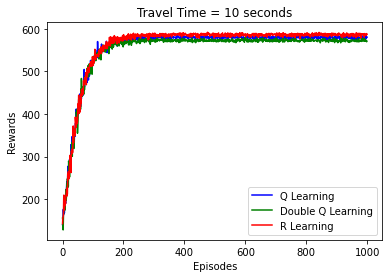

In [194]:
plt.plot(R101,color = 'blue')
plt.plot(R102,color = 'green')
plt.plot(R104,color = 'red')
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.legend(["Q Learning","Double Q Learning","R Learning"])
plt.title("Travel Time = 10 seconds")
plt.savefig("8.pdf")

In [55]:
R1 = []
R2 = []
R4 = []
R5 = []
R6 = []
R7 = []
R8 = []
for i in range(10):
    seed = 50+i
    random.seed(seed)
    rand.seed(seed)
    
    env = gym.make('gym_env:foraging-v101', interval_time = 3, decision_time="V")
    env.seed(seed)
    r1 = q_learning(env,1,alpha1,epsilon1,1000)
    r2 = double_q_learning(env,1,alpha2,epsilon2,1000)
    r4 = r_learning(env,1,alpha4,epsilon4,1000)
    r5 = q_lambda(env,1,alpha5,epsilon5,1000,0.5,True)
    r6 = q_lambda(env,1,alpha5,epsilon5,1000,0.5,False)
    r7 = sarsa_lambda(env,1,alpha5,epsilon5,1000,0.5,False)    
    r8 = sarsa_lambda(env,1,alpha5,epsilon5,1000,0.5,False)    
    
    
    R1.append(r1)
    R2.append(r2)       
    R4.append(r4)    
    R5.append(r5)    
    R6.append(r6)
    R7.append(r7)
    R8.append(r8)
    
    
R1 = np.array(R1)
R2 = np.array(R2)
R4 = np.array(R4)
R5 = np.array(R5)
R6 = np.array(R6)
R7 = np.array(R7)
R8 = np.array(R8)


R31 = np.average(R1,axis = 0)
R32 = np.average(R2,axis = 0)
R34 = np.average(R4,axis = 0)
R35 = np.average(R5,axis = 0)
R36 = np.average(R6,axis = 0)
R37 = np.average(R7,axis = 0)
R38 = np.average(R8,axis = 0)


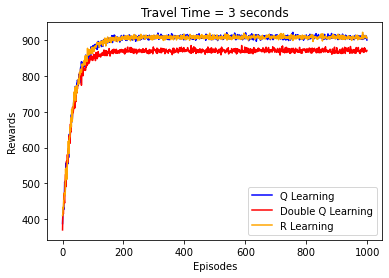

In [193]:
plt.plot(R31,color = 'blue')
plt.plot(R32,color = 'red')
plt.plot(R34,color = 'orange')
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.legend(["Q Learning","Double Q Learning","R Learning"])
plt.title("Travel Time = 3 seconds")
plt.savefig("7.pdf")

# Changes in Q lambda

In [58]:
def q_lambda_modified(env, gamma, alpha, epsilon, noEpisodes,lda,replaceTrace):
    # your code goes here
    P = np.zeros(noEpisodes)
    rho = 0
    Q = np.zeros((500,2))
    Qs = np.zeros((noEpisodes,500,2))
    R = np.zeros(noEpisodes)
    E=np.zeros((500,2))
    actions = []
    actions.append(0)
    # print(np.shape(Q)," ",np.shape(E))
    for e in range(noEpisodes):
        alpha0 = alpha[e]
        epsilon0 = epsilon[e]
        s,done = env.reset()
        a = actionSelect(Q,s,epsilon0)
        totalReward = 0
        while not done:
            sprime,r,done=env.step(a)
            aprime = actionSelect(Q,sprime,epsilon0)
            if Q[sprime][aprime]==np.amax(Q[sprime]):
                sprime_greedy = True
            else:
                sprime_greedy = False 
            R[e] += r
            totalReward += r
            td_target = r
            if not done:
                td_target = td_target + gamma*np.amax(Q[sprime])
            td_error = td_target - Q[s][a] - rho
            if replaceTrace: 
                E[s].fill(0)
            E[s][a]=E[s][a]+1
            # print(np.shape(Q)," ",np.shape(E))
            Q+=alpha0*td_error*E
            if sprime_greedy:
                E=gamma*lda*E
            else:
                E.fill(0)
            s,a=sprime,aprime
        P[e] = rho
        rho = (e*rho+(totalReward/240))/(e+1)
        
        Qs[e] = Q

    return R

In [63]:
R9 = []
R10 = []
for i in range(10):
    seed = 50+i
    random.seed(seed)
    rand.seed(seed)
    
    env = gym.make('gym_env:foraging-v101', interval_time = 10, decision_time="V")
    env.seed(seed)
    r1 = q_lambda_modified(env,1,alpha1,epsilon1,1000,0.5,True)
    r2 = q_lambda_modified(env,1,alpha1,epsilon1,1000,0.5,False)
        
    R9.append(r1)
    R10.append(r2)    

    
    
R9 = np.array(R9)
R10 = np.array(R10)



R109 = np.average(R9,axis = 0)
R1010 = np.average(R10,axis = 0)



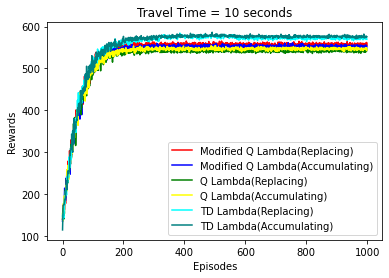

In [195]:
plt.plot(R109,color='red')
plt.plot(R1010,color = 'blue')
plt.plot(R105,color = 'green')
plt.plot(R106,color = 'yellow')
plt.plot(R107,color = 'cyan')
plt.plot(R108,color = 'teal')
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.legend(["Modified Q Lambda(Replacing)","Modified Q Lambda(Accumulating)","Q Lambda(Replacing)","Q Lambda(Accumulating)","TD Lambda(Replacing)","TD Lambda(Accumulating)"])
plt.title("Travel Time = 10 seconds")
plt.savefig("9.pdf")

In [70]:
R9 = []
R10 = []
for i in range(10):
    seed = 50+i
    random.seed(seed)
    rand.seed(seed)
    
    env = gym.make('gym_env:foraging-v101', interval_time = 3, decision_time="V")
    env.seed(seed)
    r1 = q_lambda_modified(env,1,alpha1,epsilon1,1000,0.5,True)
    r2 = q_lambda_modified(env,1,alpha1,epsilon1,1000,0.5,False)
        
    R9.append(r1)
    R10.append(r2)    

    
    
R9 = np.array(R9)
R10 = np.array(R10)



R39 = np.average(R9,axis = 0)
R310 = np.average(R10,axis = 0)



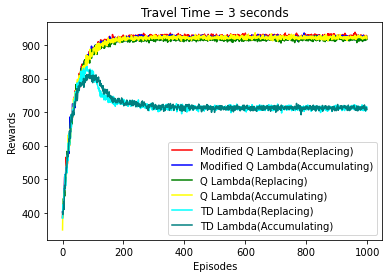

In [197]:
plt.plot(R39,color='red')
plt.plot(R310,color = 'blue')
plt.plot(R35,color = 'green')
plt.plot(R36,color = 'yellow')
plt.plot(R37,color = 'cyan')
plt.plot(R38,color = 'teal')
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.legend(["Modified Q Lambda(Replacing)","Modified Q Lambda(Accumulating)","Q Lambda(Replacing)","Q Lambda(Accumulating)","TD Lambda(Replacing)","TD Lambda(Accumulating)"])
plt.title("Travel Time = 3 seconds")
plt.savefig("10.pdf")

# Dyna Q and Its modification

In [81]:
# defining function to get visited states and action taken
def getVisitedStatesAndActionsTaken(T):
    s = []         # list to store the visited trace
    temp = []      # list to store action taken for a particular state
    a = []         # list to store action taken for all states
    for i in range(20):
        for j in range(2):
            if np.sum(T[i][j]):
                temp.append(j)
        a.append(temp)
        if len(temp):
            s.append(i)
        temp = []
    return s,a

In [82]:
# Dyna-Q
def dyna_q(env, gamma, alpha, epsilon, noEpisodes, noPlanning):
    # your code goes here
    Q = np.zeros((50,2))
    Qs = np.zeros((noEpisodes,50,2))
    T = np.zeros((50,2,50))
    R = np.zeros((50,2,50))
    Rewards = np.zeros(noEpisodes)
    for e in range(noEpisodes):
        alpha0 = alpha[e]
        epsilon0 = epsilon[e]
        E = 0
        s,done = env.reset()
        while not done:
            a = actionSelect(Q,s,epsilon0)
            sprime,r,done = env.step(a)
            T[s][a][sprime] += 1
            rDiff = r - R[s][a][sprime]
            R[s][a][sprime] += rDiff/T[s][a][sprime]
            Rewards[e] += r
            td_target = r
            if not done:
                td_target += gamma*np.amax(Q[sprime])
            td_error = td_target - Q[s][a]
            Q[s][a] = Q[s][a] + alpha0*td_error
            sbackup = sprime
            for _ in range(noPlanning):
                if np.sum(Q)==0: 
                    break
                svisited,avisited = getVisitedStatesAndActionsTaken(T)
                s = random.choice(svisited)
                a = random.choice(avisited[s])
                prob_sprime = T[s][a]/np.sum(T[s][a])
                sprime = rand.choice(50,size = 1,p = prob_sprime)[0]
                r = R[s][a][sprime]
                td_target = r+gamma*np.amax(Q[sprime])
                td_error = td_target - Q[s][a]
                Q[s][a] = Q[s][a] + alpha0*td_error
                
            s = sbackup
        
        # Book_Keeping
        Qs[e] = Q
    return Rewards

In [96]:
R11 = []

for i in range(10):
    seed = 50+i
    random.seed(seed)
    rand.seed(seed)
    
    env = gym.make('gym_env:foraging-v101', interval_time = 10, decision_time="V")
    env.seed(seed)
    r1 = dyna_q(env,1,alpha1,epsilon1,1000,2)
        
    R11.append(r1)
    
R11 = np.array(R11)

R1011 = np.average(R11,axis = 0)

In [126]:
R11 = []

for i in range(10):
    seed = 50+i
    random.seed(seed)
    rand.seed(seed)
    
    env = gym.make('gym_env:foraging-v101', interval_time = 3, decision_time="V")
    env.seed(seed)
    r1 = dyna_q(env,1,alpha1,epsilon1,1000,2)
        
    R11.append(r1)
    
R11 = np.array(R11)

R311 = np.average(R11,axis = 0)

In [98]:
# Dyna-Q
def dyna_q_modified(env, gamma, alpha, epsilon, noEpisodes, noPlanning):
    # your code goes here
    P = np.zeros(noEpisodes)
    rho = 0
    Q = np.zeros((50,2))
    Qs = np.zeros((noEpisodes,50,2))
    T = np.zeros((50,2,50))
    R = np.zeros((50,2,50))
    Rewards = np.zeros(noEpisodes)
    for e in range(noEpisodes):
        alpha0 = alpha[e]
        epsilon0 = epsilon[e]
        E = 0
        s,done = env.reset()
        totalReward = 0
        while not done:
            a = actionSelect(Q,s,epsilon0)
            sprime,r,done = env.step(a)
            T[s][a][sprime] += 1
            rDiff = r - R[s][a][sprime]
            R[s][a][sprime] += rDiff/T[s][a][sprime]
            Rewards[e] += r
            totalReward += r
            td_target = r
            if not done:
                td_target += gamma*np.amax(Q[sprime])
            td_error = td_target - Q[s][a] - rho
            Q[s][a] = Q[s][a] + alpha0*td_error
            sbackup = sprime
            for _ in range(noPlanning):
                if np.sum(Q)==0: 
                    break
                svisited,avisited = getVisitedStatesAndActionsTaken(T)
                s = random.choice(svisited)
                a = random.choice(avisited[s])
                prob_sprime = T[s][a]/np.sum(T[s][a])
                sprime = rand.choice(50,size = 1,p = prob_sprime)[0]
                r = R[s][a][sprime]
                td_target = r+gamma*np.amax(Q[sprime])
                td_error = td_target - Q[s][a] - rho
                Q[s][a] = Q[s][a] + alpha0*td_error
                
            s = sbackup
        # Book_Keeping
        P[e] = rho
        rho = (e*rho+(totalReward/240))/(e+1)
        Qs[e] = Q
    return Rewards

In [99]:
R12 = []

for i in range(10):
    seed = 50+i
    random.seed(seed)
    rand.seed(seed)
    
    env = gym.make('gym_env:foraging-v101', interval_time = 10, decision_time="V")
    env.seed(seed)
    r1 = dyna_q_modified(env,1,alpha1,epsilon1,1000,2)
        
    R12.append(r1)
    
R12 = np.array(R12)

R1012 = np.average(R12,axis = 0)

In [129]:
R12 = []

for i in range(10):
    seed = 50+i
    random.seed(seed)
    rand.seed(seed)
    
    env = gym.make('gym_env:foraging-v101', interval_time = 3, decision_time="V")
    env.seed(seed)
    r1 = dyna_q_modified(env,1,alpha1,epsilon1,1000,2)
        
    R12.append(r1)
    
R12 = np.array(R12)

R312 = np.average(R12,axis = 0)

# Trajectory Sampling

In [114]:
# Trajectory sampling
def trajectory_sampling(env, gamma, alpha, epsilon, noEpisodes, maxTrajectory):
    # your code goes here
    Q = np.zeros((20,2))
    Qs = np.zeros((noEpisodes,20,2))
    Vs = np.zeros((noEpisodes,20))
    Ps = np.zeros((noEpisodes,20))
    T = np.zeros((20,2,20))
    R = np.zeros((20,2,20))
    Rewards = np.zeros(noEpisodes)
    for e in range(noEpisodes):
        alpha0 = alpha[e]
        epsilon0 = epsilon[e]
        E = 0
        s,done = env.reset()
        while not done:
            a = actionSelect(Q,s,epsilon0)
            sprime,r,done = env.step(a)
            T[s][a][sprime] += 1
            rDiff = r - R[s][a][sprime]
            R[s][a][sprime] += rDiff/T[s][a][sprime]
            td_target = r
            Rewards[e] += r
            if not done:
                td_target += gamma*np.amax(Q[sprime])
            td_error = td_target - Q[s][a]
            Q[s][a] = Q[s][a] + alpha0*td_error
            sbackup = sprime
            for _ in range(maxTrajectory):
                if np.sum(Q)==0: 
                    break
                a = np.argmax(Q[s])
                if not np.sum(T[s][a]):
                    break
                prob_sprime = (T[s][a])/(np.sum(T[s][a]))
                sprime = rand.choice(20,size = 1,p = prob_sprime)[0]
                r = R[s][a][sprime]
                td_target = r+gamma*np.amax(Q[sprime])
                td_error = td_target - Q[s][a]
                Q[s][a] = Q[s][a] + alpha0*td_error
                s = sprime
            s = sbackup
        #Book-Keeping
        Qs[e] = Q
    return Rewards

In [115]:
R13 = []

for i in range(10):
    seed = 50+i
    random.seed(seed)
    rand.seed(seed)
    
    env = gym.make('gym_env:foraging-v101', interval_time = 10, decision_time="V")
    env.seed(seed)
    r1 = trajectory_sampling(env,1,alpha1,epsilon1,1000,2)
    
    R13.append(r1)
       
R13 = np.array(R13)

R1013 = np.average(R13,axis = 0)

In [117]:
# Trajectory sampling
def trajectory_sampling_modified(env, gamma, alpha, epsilon, noEpisodes, maxTrajectory):
    # your code goes here
    P = np.zeros(noEpisodes)
    rho = 0
    Q = np.zeros((20,2))
    Qs = np.zeros((noEpisodes,20,2))
    Vs = np.zeros((noEpisodes,20))
    Ps = np.zeros((noEpisodes,20))
    T = np.zeros((20,2,20))
    R = np.zeros((20,2,20))
    Rewards = np.zeros(noEpisodes)
    for e in range(noEpisodes):
        alpha0 = alpha[e]
        epsilon0 = epsilon[e]
        E = 0
        s,done = env.reset()
        totalReward = 0
        while not done:
            a = actionSelect(Q,s,epsilon0)
            sprime,r,done = env.step(a)
            T[s][a][sprime] += 1
            rDiff = r - R[s][a][sprime]
            R[s][a][sprime] += rDiff/T[s][a][sprime]
            td_target = r
            Rewards[e] += r
            totalReward += r
            if not done:
                td_target += gamma*np.amax(Q[sprime])
            td_error = td_target - Q[s][a] - rho
            Q[s][a] = Q[s][a] + alpha0*td_error
            sbackup = sprime
            for _ in range(maxTrajectory):
                if np.sum(Q)==0: 
                    break
                a = np.argmax(Q[s])
                if not np.sum(T[s][a]):
                    break
                prob_sprime = (T[s][a])/(np.sum(T[s][a]))
                sprime = rand.choice(20,size = 1,p = prob_sprime)[0]
                r = R[s][a][sprime]
                td_target = r+gamma*np.amax(Q[sprime])
                td_error = td_target - Q[s][a] - rho
                Q[s][a] = Q[s][a] + alpha0*td_error
                s = sprime
            s = sbackup
        #Book-Keeping
        P[e] = rho
        rho = (e*rho+(totalReward/240))/(e+1)
        Qs[e] = Q
    return Rewards

In [120]:
R14 = []

for i in range(10):
    seed = 50+i
    random.seed(seed)
    rand.seed(seed)
    
    env = gym.make('gym_env:foraging-v101', interval_time = 10, decision_time="V")
    env.seed(seed)
    r1 = trajectory_sampling_modified(env,1,alpha1,epsilon1,1000,3)
    
    R14.append(r1)
       
R14 = np.array(R14)

R1014 = np.average(R14,axis = 0)

In [131]:
R13 = []

for i in range(10):
    seed = 50+i
    random.seed(seed)
    rand.seed(seed)
    
    env = gym.make('gym_env:foraging-v101', interval_time = 3, decision_time="V")
    env.seed(seed)
    r1 = trajectory_sampling(env,1,alpha1,epsilon1,1000,2)
    
    R13.append(r1)
       
R13 = np.array(R13)

R313 = np.average(R13,axis = 0)

In [132]:
R14 = []

for i in range(10):
    seed = 50+i
    random.seed(seed)
    rand.seed(seed)
    
    env = gym.make('gym_env:foraging-v101', interval_time = 3, decision_time="V")
    env.seed(seed)
    r1 = trajectory_sampling_modified(env,1,alpha1,epsilon1,1000,3)
    
    R14.append(r1)
       
R14 = np.array(R14)

R314 = np.average(R14,axis = 0)

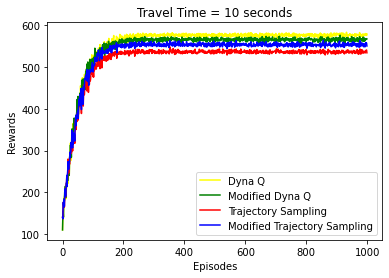

In [199]:
plt.plot(R1011,color = 'yellow')
plt.plot(R1012,color = 'green')
plt.plot(R1013,color = 'red')
plt.plot(R1014,color = 'blue')
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.legend(["Dyna Q","Modified Dyna Q","Trajectory Sampling","Modified Trajectory Sampling"])
plt.title("Travel Time = 10 seconds")
plt.savefig("12.pdf")

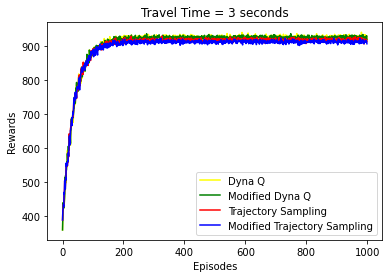

In [198]:
plt.plot(R311,color = 'yellow')
plt.plot(R312,color = 'green')
plt.plot(R313,color = 'red')
plt.plot(R314,color = 'blue')
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.legend(["Dyna Q","Modified Dyna Q","Trajectory Sampling","Modified Trajectory Sampling"])
plt.title("Travel Time = 3 seconds")
plt.savefig("11.pdf")

# Comparison between Agents

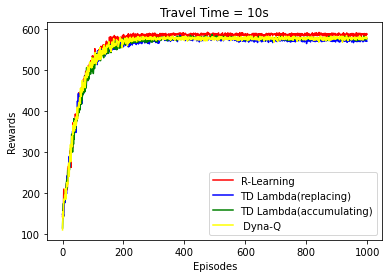

In [163]:
plt.plot(R104, color = 'red')
plt.plot(R107, color = 'blue')
plt.plot(R108, color = 'green')
plt.plot(R1011, color = 'yellow')
# plt.ylim((550,600))
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.legend(["R-Learning", "TD Lambda(replacing)","TD Lambda(accumulating)"," Dyna-Q"])
plt.title("Travel Time = 10s")
plt.savefig("1.pdf")

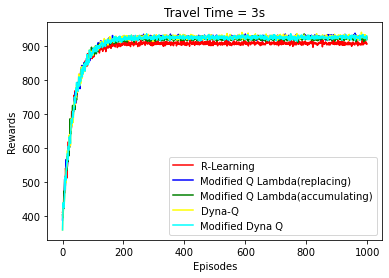

In [167]:
plt.plot(R34,color = 'red')
plt.plot(R39,color = 'blue')
plt.plot(R310,color ='green')
plt.plot(R311,color ='yellow' )
plt.plot(R312,color ='cyan' )
# plt.ylim((880,950))
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.legend(["R-Learning", "Modified Q Lambda(replacing)","Modified Q Lambda(accumulating)","Dyna-Q", "Modified Dyna Q"])
plt.title("Travel Time = 3s")
plt.savefig("2.pdf")


# Comparison in no of harvests and decision time

In [186]:
def r_learning(env, gamma, alpha, epsilon, noEpisodes):
    # your code goes here
    P=np.zeros(noEpisodes)
    rho=0
    Q = np.zeros((500,2))
    Qs = np.zeros((noEpisodes,500,2))
    R = np.zeros(noEpisodes)
    actions = []
    actions.append(0)
    for e in range(noEpisodes):
        alpha0 = alpha[e]
        epsilon0 = epsilon[e]
        s,done = env.reset()
        totalReward=0
        while not done:
            a = actionSelect(Q,s,epsilon0)
            if e == noEpisodes-1:
                if a==0:
                    actions.append(0)
                else:
                    actions[-1]+=1
            # print(a)
            sprime,r,done= env.step(a)
            R[e] += r
            totalReward+=r
            td_target = r
            if not done:
                td_target = td_target + gamma*np.amax(Q[sprime])
            td_error = td_target - Q[s][a]-rho
            # td_error = td_target - Q[s][a]
            Q[s][a] = Q[s][a] + alpha0*td_error
            
            s = sprime
        P[e]=rho
        rho=(e*rho+(totalReward/240))/(e+1)

        Qs[e] = Q
    
    return R,actions

In [189]:
DQR1 = []
DQR2 = []
DQR3 = []
DQR4 = []

for i in range(10):
    seed = 50+i
    random.seed(seed)
    rand.seed(seed)
    
    env1 = gym.make('gym_env:foraging-v101', interval_time = 10, decision_time="V")
    env2 = gym.make('gym_env:foraging-v101', interval_time = 10, decision_time="H")
    env3 = gym.make('gym_env:foraging-v101', interval_time = 10, decision_time="L")
    env4 = gym.make('gym_env:foraging-v101', interval_time = 10, decision_time="N")
    
    env1.seed(seed)
    env2.seed(seed)
    env3.seed(seed)
    env4.seed(seed)
    
    r1,a1 = r_learning(env1,1,alpha1,epsilon1,1000)
    r2,a2 = r_learning(env2,1,alpha1,epsilon1,1000)
    r3,a3 = r_learning(env3,1,alpha1,epsilon1,1000)
    r4,a4 = r_learning(env4,1,alpha1,epsilon1,1000)
    

    
    DQR1.append(r1)
    DQR2.append(r2)
    DQR3.append(r3)
    DQR4.append(r4)
    
       
DQR1 = np.array(DQR1)
DQR2 = np.array(DQR2)
DQR3 = np.array(DQR3)
DQR4 = np.array(DQR4)


DQR31 = np.average(DQR1,axis = 0)
DQR32 = np.average(DQR2,axis = 0)
DQR33 = np.average(DQR3,axis = 0)
DQR34 = np.average(DQR4,axis = 0)

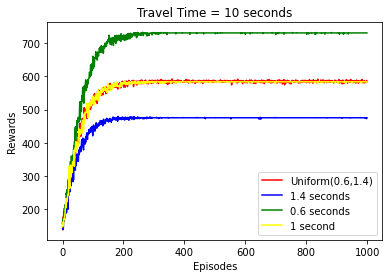

In [190]:
plt.plot(DQR31,color = 'red')
plt.plot(DQR32,color = 'blue')
plt.plot(DQR33,color = 'green')
plt.plot(DQR34,color = 'yellow')
plt.legend(["Uniform(0.6,1.4)","1.4 seconds","0.6 seconds","1 second"])
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("Travel Time = 10 seconds")
# plt.figure(figsize = (15,7))
plt.savefig("5.pdf")

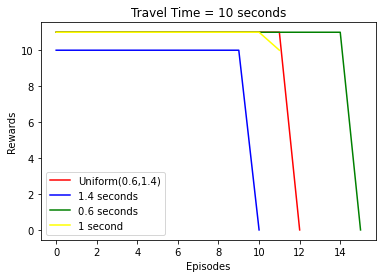

In [191]:
plt.plot(a1,color = 'red')
plt.plot(a2,color = 'blue')
plt.plot(a3,color = 'green')
plt.plot(a4,color = 'yellow')
plt.legend(["Uniform(0.6,1.4)","1.4 seconds","0.6 seconds","1 second"])
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("Travel Time = 10 seconds")
plt.savefig("6.pdf")


In [151]:
def q_lambda_modified(env, gamma, alpha, epsilon, noEpisodes,lda,replaceTrace):
    # your code goes here
    P = np.zeros(noEpisodes)
    rho = 0
    Q = np.zeros((500,2))
    Qs = np.zeros((noEpisodes,500,2))
    R = np.zeros(noEpisodes)
    E=np.zeros((500,2))
    actions = []
    actions.append(0)
    # print(np.shape(Q)," ",np.shape(E))
    for e in range(noEpisodes):
        alpha0 = alpha[e]
        epsilon0 = epsilon[e]
        s,done = env.reset()
        a = actionSelect(Q,s,epsilon0)
        totalReward = 0
        while not done:
            sprime,r,done=env.step(a)
            aprime = actionSelect(Q,sprime,epsilon0)
            if Q[sprime][aprime]==np.amax(Q[sprime]):
                sprime_greedy = True
            else:
                sprime_greedy = False 
            if e==noEpisodes-1:
                if a==0:
                    actions.append(0)
                else:
                    actions[-1]+=1
            R[e] += r
            totalReward += r
            td_target = r
            if not done:
                td_target = td_target + gamma*np.amax(Q[sprime])
            td_error = td_target - Q[s][a] - rho
            if replaceTrace: 
                E[s].fill(0)
            E[s][a]=E[s][a]+1
            # print(np.shape(Q)," ",np.shape(E))
            Q+=alpha0*td_error*E
            if sprime_greedy:
                E=gamma*lda*E
            else:
                E.fill(0)
            s,a=sprime,aprime
        P[e] = rho
        rho = (e*rho+(totalReward/240))/(e+1)
        
        Qs[e] = Q

    return R,actions

In [152]:
DQR1 = []
DQR2 = []
DQR3 = []
DQR4 = []

for i in range(10):
    seed = 50+i
    random.seed(seed)
    rand.seed(seed)
    
    env1 = gym.make('gym_env:foraging-v101', interval_time = 3, decision_time="V")
    env2 = gym.make('gym_env:foraging-v101', interval_time = 3, decision_time="H")
    env3 = gym.make('gym_env:foraging-v101', interval_time = 3, decision_time="L")
    env4 = gym.make('gym_env:foraging-v101', interval_time = 3, decision_time="N")
    
    env1.seed(seed)
    env2.seed(seed)
    env3.seed(seed)
    env4.seed(seed)
    
    r1,a1 = q_lambda_modified(env1,1,alpha1,epsilon1,1000,0.5,True)
    r2,a2 = q_lambda_modified(env2,1,alpha1,epsilon1,1000,0.5,True)
    r3,a3 = q_lambda_modified(env3,1,alpha1,epsilon1,1000,0.5,True)
    r4,a4 = q_lambda_modified(env4,1,alpha1,epsilon1,1000,0.5,True)
    

    
    DQR1.append(r1)
    DQR2.append(r2)
    DQR3.append(r3)
    DQR4.append(r4)
    
       
DQR1 = np.array(DQR1)
DQR2 = np.array(DQR2)
DQR3 = np.array(DQR3)
DQR4 = np.array(DQR4)


DQR31 = np.average(DQR1,axis = 0)
DQR32 = np.average(DQR2,axis = 0)
DQR33 = np.average(DQR3,axis = 0)
DQR34 = np.average(DQR4,axis = 0)

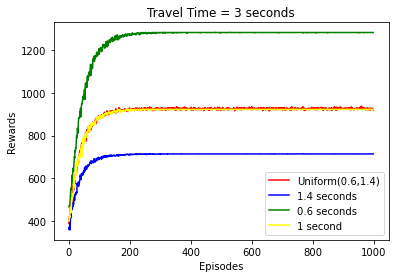

In [187]:
plt.plot(DQR31,color = 'red')
plt.plot(DQR32,color = 'blue')
plt.plot(DQR33,color = 'green')
plt.plot(DQR34,color = 'yellow')
plt.legend(["Uniform(0.6,1.4)","1.4 seconds","0.6 seconds","1 second"])
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("Travel Time = 3 seconds")
# plt.figure(figsize = (15,7))
plt.savefig("3.pdf")

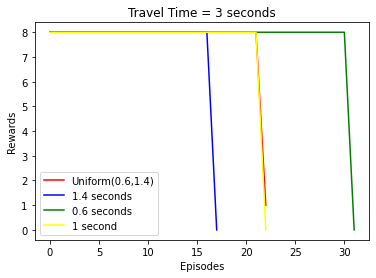

In [188]:
plt.plot(a1,color = 'red')
plt.plot(a2,color = 'blue')
plt.plot(a3,color = 'green')
plt.plot(a4,color = 'yellow')
plt.legend(["Uniform(0.6,1.4)","1.4 seconds","0.6 seconds","1 second"])
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("Travel Time = 3 seconds")
plt.savefig("4.pdf")
